# Linear Progamming with Microsoft Z3

Z3 (https://github.com/Z3Prover/z3/releases) is a theorem prover from Microsoft Research, the below example walks through how it could be used instead of PuLP + Cbc to solver a linear-programming problem. The towing example from "Example-3" is thus replicated using Z3.

In [1]:
from z3 import *

In [74]:
# Small modification from Pulp to Z3
def plot_gantt_chart(allocated_turns, lp_variable_outcomes, min_bucket=5):
    for alloc in lp_variable_outcomes:
        # Comment out below line:
        #if lp_variable_outcomes[alloc].varValue:
        allocated_turns.set_value(allocated_turns['turn_no'] == alloc[0], 'gate', alloc[-1])
    time_series = pd.Series(True, index= pd.date_range(
            start=turns2.inbound_arrival.min(),
            end=turns2.outbound_departure.max(),
            freq=pd.offsets.Minute(min_bucket)))
    def trunc_ts(series):
        return time_series.truncate(series['inbound_arrival'], series['outbound_departure'])
    allocheatmapdf = allocated_turns.apply(trunc_ts, axis=1).T
    allocheatmapdf.columns = allocated_turns['turn_no'].get_values()
    allocheatmapdf = allocheatmapdf.fillna(0).astype(int)
    allocheatmapdf.index = allocheatmapdf.index.time
    for col in list(allocheatmapdf.columns):
        allocheatmapdf.loc[allocheatmapdf[col] > 0, col] = col
    allocheatmapdf.columns = allocated_turns['gate'].get_values()  
    trans = allocheatmapdf.T
    plt_df = trans.groupby(trans.index).sum()
    sns.set()
    plt.figure(figsize=(20, 10))
    g = sns.heatmap(plt_df, xticklabels=10, cmap='nipy_spectral')

## Step 1/2: Data Wrangling to prepare for Linear Programming (same as before ...)

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from pulp import *
import pickle

In [4]:
# Load previous
airport = pickle.load(open("airport.p", "rb"))

turns2 = pickle.load(open("turns2.p", "rb"))
turns2.drop('gate', axis=1, inplace=True)

occupancy = pickle.load(open("occupancy.p", "rb"))

In [6]:
# Add two special 'rest' gates for towing
extra_gates = pd.DataFrame({
    'terminal':['rest','rest'],
    'gate':['R1','R2'],
    'max_size':[3,3]
    }, columns=['terminal', 'gate', 'max_size'])

airport = airport.append(extra_gates, ignore_index = True)
airport

,terminal,gate,max_size
0,A,A1,3
1,A,A2,1
2,A,A3,2
3,B,B1,3
4,C,C1,1
5,C,C2,1
6,rest,R1,3
7,rest,R2,3


In [8]:
TOW_MINIMUM_HOURS = 5

# Filter on more than 2 hours and duplicate
dur = (turns2.outbound_departure - turns2.inbound_arrival).astype('timedelta64[h]')
eligible_for_tow = turns2[dur > TOW_MINIMUM_HOURS]
eligible_for_tow = eligible_for_tow.append(eligible_for_tow, ignore_index=True)

# Add back to original
turns2 = turns2.append(eligible_for_tow, ignore_index=True)

# Turn_part
turns2['turn_part'] = turns2.groupby('turn_no')['turn_no'].rank(method='first')
# Zero if no tow
cnt_parts = turns2.groupby("turn_no")["turn_no"].transform('count')
turns2.loc[cnt_parts==1, "turn_part"] = 0
# Sort
turns2.sort_values(['turn_no', 'turn_part'], inplace=True)

In [9]:
# We will later create disrete time-buckets
# To prevent split turns from 'overlapping' with each other under we give some buffer:
min_bucket=5

# Part 1
turns2.loc[turns2.turn_part==1, "outbound_departure"] = turns2.inbound_arrival + pd.offsets.Hour(1)
# Part 2
turns2.loc[turns2.turn_part==2, "inbound_arrival"] = turns2.inbound_arrival + pd.offsets.Minute(60 + min_bucket)
turns2.loc[turns2.turn_part==2, "outbound_departure"] = turns2.outbound_departure - pd.offsets.Minute(60 + min_bucket)
# Part 3
turns2.loc[turns2.turn_part==3, "inbound_arrival"] = turns2.outbound_departure - pd.offsets.Hour(1)

In [10]:
# Create new-id and reset columns
turns2.reset_index(drop=True, inplace=True)
turns2.rename(columns={'turn_no': 'original_turn'}, inplace=True)
turns2['turn_no'] = turns2.index

In [11]:
turn_list = turns2.turn_no.get_values()
gate_list = airport.gate.get_values()

compatible_gates = {}
for idx, row in turns2.iterrows():
    gates_lst = airport[airport.max_size >= row.plane_size].gate.get_values()
    compatible_gates[row.turn_no] = gates_lst

In [12]:
turns2

,original_turn,plane_size,from_country,to_country,inbound_arrival,outbound_departure,turn_part,turn_no
0,1,2,GB,CZ,2016-02-01 06:05:00,2016-02-01 07:05:00,0.0,0
1,2,3,GB,CZ,2016-02-01 06:05:00,2016-02-01 09:05:00,0.0,1
2,3,2,US,CZ,2016-02-01 09:10:00,2016-02-01 10:10:00,1.0,2
3,3,2,US,CZ,2016-02-01 10:15:00,2016-02-01 14:05:00,2.0,3
4,3,2,US,CZ,2016-02-01 14:10:00,2016-02-01 15:10:00,3.0,4
5,4,1,TR,FR,2016-02-01 09:10:00,2016-02-01 13:10:00,0.0,5
6,5,1,RU,FR,2016-02-01 09:10:00,2016-02-01 10:10:00,1.0,6
7,5,1,RU,FR,2016-02-01 10:15:00,2016-02-01 16:05:00,2.0,7
8,5,1,RU,FR,2016-02-01 16:10:00,2016-02-01 17:10:00,3.0,8
9,6,1,FR,GB,2016-02-01 12:15:00,2016-02-01 15:15:00,0.0,9


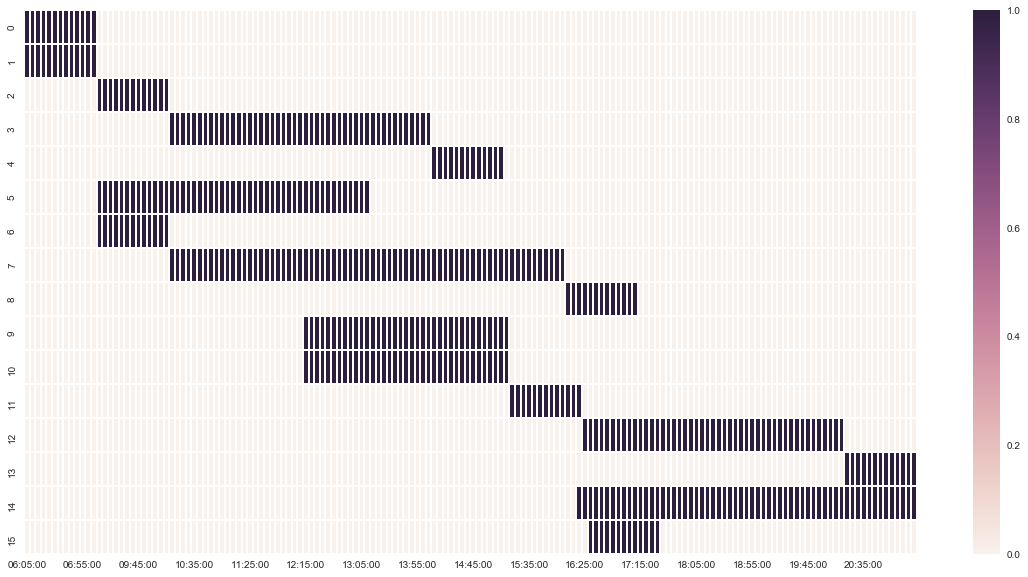

In [13]:
# Here we create the discrete time-buckets dataframe just like before ...
# ("Example-1") ...

# Create time-series between arrival of first plane and departure of last
time_series = pd.Series(True, index= pd.date_range(
        start=turns2.inbound_arrival.min(),
        end=turns2.outbound_departure.max(),
        freq=pd.offsets.Minute(min_bucket)))
    
# Truncate full time-series to [inbound_arrival, outbound_departure]
def trunc_ts(series):
    return time_series.truncate(series['inbound_arrival'], series['outbound_departure'])
    
heatmapdf = turns2.apply(trunc_ts, axis=1).T
    
# Convert columns from index to turn_no
heatmapdf.columns = turns2['turn_no'].get_values()
# Cast to integer
heatmapdf = heatmapdf.fillna(0).astype(int)
heatmapdf.index = heatmapdf.index.time

heatmapdf['tot'] = heatmapdf.sum(axis=1)
heatmapdf = heatmapdf[heatmapdf.tot > 1]
heatmapdf.drop(['tot'], axis=1, inplace=True)

# Plot the turns in the airport
sns.set()
plt.figure(figsize=(20, 10))

snsdf = heatmapdf.T
g = sns.heatmap(snsdf, rasterized=True, xticklabels=10, linewidths=1)

## Step 2/2: Linear Programming with Z3

In [14]:
def BoolVar(s, v):
    """ Create a boolean variable for Z3 """
    x = Int(v)
    s.add(0 <= x, x <= 1)
    return x

In [16]:
# 0. Initialise model
#prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost
# Pulp to Z3
prob = Optimize()

# 1. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    # For compatible gates
    for g in compatible_gates[t]:
        if g in occupancy.gate.get_values():
            
            t_dep = turns2.loc[turns2['turn_no']== t, 'outbound_departure'].values[0]
            t_arr = turns2.loc[turns2['turn_no']== t, 'inbound_arrival'].values[0]
            oc_from = occupancy.loc[occupancy['gate']== g, 'occupied_from'].values[0]
            oc_to = occupancy.loc[occupancy['gate']== g, 'occupied_to'].values[0]
            
            if (oc_to >= t_arr) and (oc_from <= t_dep):
                continue
                
        # Gate not occupied so create variable
        #x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)
        # Pulp to Z3
        x[t, g] = BoolVar(prob, "t%i_g%s" % (t, g))

# 2. Constraints
# i. Each turn must be assigned to one compatible gate
for t in turn_list:
    #prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1
    # Pulp to Z3
    prob += (Sum([x[t, g] for g in gate_list if (t, g) in x]) == 1)
    
# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        if len(cons) > 1:
            #constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            #prob += constraint_for_time_bucket
            # Pulp to Z3
            prob += (Sum(cons) <= IntVal(1))

In [18]:
w = {} # Create dictionary for tows
tow_turns = turns2[turns2.turn_part>0].turn_no.get_values() # List of potential tows

for tow_turn in tow_turns:
    #w[tow_turn] = LpVariable("towing(%s)" % (tow_turn), 0, 1, LpBinary)
    # Pulp to Z3
    w[tow_turn] = BoolVar(prob, "towing(%s)" % (tow_turn))
    
print(w)

{2: towing(2), 3: towing(3), 4: towing(4), 6: towing(6), 7: towing(7), 8: towing(8), 11: towing(11), 12: towing(12), 13: towing(13)}


In [19]:
# Remind ourselves of the turns ...
turns2[turns2.turn_part>0]

,original_turn,plane_size,from_country,to_country,inbound_arrival,outbound_departure,turn_part,turn_no
2,3,2,US,CZ,2016-02-01 09:10:00,2016-02-01 10:10:00,1.0,2
3,3,2,US,CZ,2016-02-01 10:15:00,2016-02-01 14:05:00,2.0,3
4,3,2,US,CZ,2016-02-01 14:10:00,2016-02-01 15:10:00,3.0,4
6,5,1,RU,FR,2016-02-01 09:10:00,2016-02-01 10:10:00,1.0,6
7,5,1,RU,FR,2016-02-01 10:15:00,2016-02-01 16:05:00,2.0,7
8,5,1,RU,FR,2016-02-01 16:10:00,2016-02-01 17:10:00,3.0,8
11,8,1,US,GB,2016-02-01 15:20:00,2016-02-01 16:20:00,1.0,11
12,8,1,US,GB,2016-02-01 16:25:00,2016-02-01 20:15:00,2.0,12
13,8,1,US,GB,2016-02-01 20:20:00,2016-02-01 21:20:00,3.0,13


In [20]:
# Map original turn to new turns (to group them)
tow_dic = {k: g["turn_no"].tolist() for k,g in turns2[turns2.turn_part>0].groupby("original_turn")}
print(tow_dic)  # Original turns 3, 5, 8 are eligible for towing

{8: [11, 12, 13], 3: [2, 3, 4], 5: [6, 7, 8]}


In [22]:
# Create tow-constraint
for k, v in tow_dic.items():
    print(k, v)
    for stand in gate_list:
        if ((v[0], stand) in x) and ((v[1], stand) in x):
            tow_out = x[v[0], stand] <= w[v[0]] + x[v[1], stand]
            prob += tow_out
        if ((v[1], stand) in x) and ((v[2], stand) in x):
            tow_in =  x[v[1], stand] <= w[v[1]] + x[v[2], stand]
            prob += tow_in

8 [11, 12, 13]
3 [2, 3, 4]
5 [6, 7, 8]


In [23]:
# Only part-2 can go to the 'rest-gates'
for t in turn_list:
    if turns2.loc[turns2['turn_no']== t, 'turn_part'].values[0] != 2:
        for stand in ["R1", "R2"]:
            prob += x[t, stand] == 0
    else:
        print(t)

3
7
12


In [24]:
# Add to objective with positive cost
# We should get no tows because they are costly and since no new turns are added we know
# ... the previous gates can handle them all
# If the cost is negative or 0 then tows can occur ...
pos_cost_coefficient = 100
#tow_objective = lpSum(pos_cost_coefficient*w[t] for t in w) 
# Pulp to Z3
tow_objective = Sum([pos_cost_coefficient*w[t] for t in w])
print(tow_objective)
#prob += tow_objective
# Pulp to Z3
prob.minimize(tow_objective)

100*towing(2) +
100*towing(3) +
100*towing(4) +
100*towing(6) +
100*towing(7) +
100*towing(8) +
100*towing(11) +
100*towing(12) +
100*towing(13)


In [73]:
# Solve
#prob.solve()
prob.check()

# Report
#print("Status: ", LpStatus[prob.status])
#print("Minimised Cost: ", value(prob.objective))

# Allocations
#for alloc in x:
#    if x[alloc].varValue:
#        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))

# Pulp to Z3
z3_allocs = prob.model()

# Print variables equal to 1
lp_var_outcomes = []
for al_key, al_val in x.items():
    if z3_allocs[al_val] == 1:
        print("Turn %i assigned to gate %s" % (al_key[0], al_key[-1]))
        lp_var_outcomes.append([al_key[0], al_key[-1]])

Turn 1 assigned to gate B1
Turn 9 assigned to gate C1
Turn 6 assigned to gate A1
Turn 5 assigned to gate A2
Turn 14 assigned to gate C2
Turn 3 assigned to gate A3
Turn 11 assigned to gate C1
Turn 2 assigned to gate A3
Turn 0 assigned to gate A1
Turn 10 assigned to gate B1
Turn 15 assigned to gate B1
Turn 8 assigned to gate A1
Turn 12 assigned to gate C1
Turn 13 assigned to gate C1
Turn 7 assigned to gate A1
Turn 4 assigned to gate A3


In [77]:
# print(prob)  # This will output the generated model in format for solver

In [66]:
#for tow in w:
#    print("Towing turn %i" % tow, bool(w[tow].varValue))
# Pulp to Z3
for tow_key, tow_val in w.items():
    print("Towing turn %i" % tow_key, z3_allocs[tow_val])

Towing turn 2 0
Towing turn 3 0
Towing turn 4 0
Towing turn 6 0
Towing turn 7 0
Towing turn 8 0
Towing turn 11 0
Towing turn 12 0
Towing turn 13 0


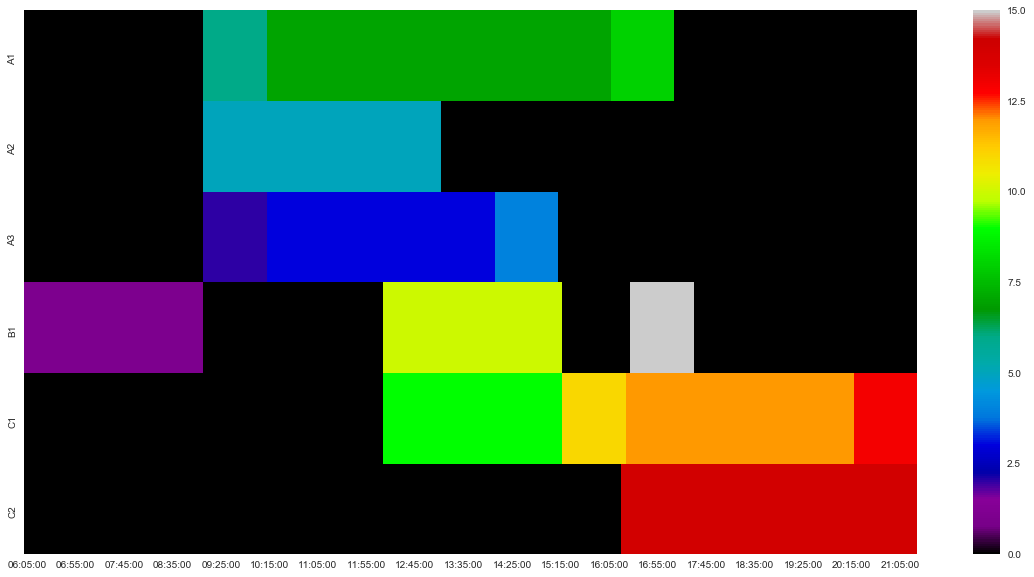

In [75]:
plot_gantt_chart(turns2, lp_var_outcomes)